In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats
import qc_utils.matplotlib_setup as mpl_setup
import multiprocess as mp

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [8]:
dx = 7
dz = 7
dm = 3

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
patch.noise_params.cosmic_ray_params.model = RayModelType.SCRAMBLING

mpmath.mp.dps = 50

In [9]:
baseline_result = sinter.collect(tasks=[patch.patch.get_sinter_task(observable_basis='Z')], num_workers=6, decoders='pymatching', max_shots=10**6, max_errors=500)[0]
print(f'{baseline_result.errors / baseline_result.shots:0.3e}')

6.200e-05


In [10]:
baseline_detections = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [11]:
sim = RayImpactSimulator(patch, 1)

In [12]:
def get_qubit_rates(detector_fractions, syndrome_qubits):
    rates = {}
    for i, syndrome_qubit in enumerate(syndrome_qubits):
        rates[syndrome_qubit.idx] = detector_fractions[i]
    return rates

In [13]:
baseline_qubit_rates = get_qubit_rates(baseline_detections, syndrome_qubits)

In [89]:
min_radius = 2
max_radius = 7
num_rays = 1000

def get_num_cycles(radius):
    if radius >= 6:
        num_cycles = 1*6*3
    elif radius >= 4:
        num_cycles = 2*6*3
    elif radius >= 3:
        num_cycles = 3*6*3
    elif radius >= 2:
        num_cycles = 7*6*3
    else:
        num_cycles = 10*6*3
    return num_cycles

def get_signal_chance_and_task(i):
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
    patch.noise_params.cosmic_ray_params.model = RayModelType.DIRECT
    center_qubit = np.random.randint(0, len(patch.patch.all_qubits))
    radius = np.random.uniform(min_radius, max_radius)
    patch.force_cosmic_ray(center_qubit, radius)

    sim = RayImpactSimulator(patch, (2 if radius >= 2 else 1))
    temporal_window_size = 1*6*3
    num_cycles = get_num_cycles(radius)
    detection_fpr = 1e-10

    ray_detector_rates = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
    ray_qubit_rates = get_qubit_rates(ray_detector_rates, syndrome_qubits)

    signal_chance = sim.calc_signal_chance(baseline_qubit_rates, ray_qubit_rates, num_cycles, temporal_window_size, detection_fpr)
    task = patch.patch.get_sinter_task(task_kwargs={'json_metadata':{'i':i, 'center_qubit':center_qubit, 'radius':radius}})

    return signal_chance, task

with mp.Pool(6) as pool:
    combined_results = pool.map(get_signal_chance_and_task, range(num_rays))

signal_chances_direct = [result[0] for result in combined_results]
tasks_direct = [result[1] for result in combined_results]

In [90]:
results_direct = sinter.collect(tasks=tasks_direct, num_workers=6, decoders='pymatching', max_shots=10**6, max_errors=500)

In [91]:
lers_direct = [None]*num_rays
radii = [0]*num_rays
for task_result in results_direct:
    lers_direct[task_result.json_metadata['i']] = task_result.errors / task_result.shots
    radii[task_result.json_metadata['i']] = task_result.json_metadata['radius']

In [92]:
import pickle
with open('data/detection_direct_results.pkl', 'wb') as f:
    pickle.dump({
        'signal_chances': signal_chances_direct,
        'lers': lers_direct,
        'radii': radii
    }, f)

/var/folders/vy/pypq_bm52_50g15jqc51yyr80000gp/T/ipykernel_40422/3799754913.py:20: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = mpl_toolkits.axes_grid1.inset_locator.InsetPosition(ax1, [0.4,0.3,0.5,0.5])


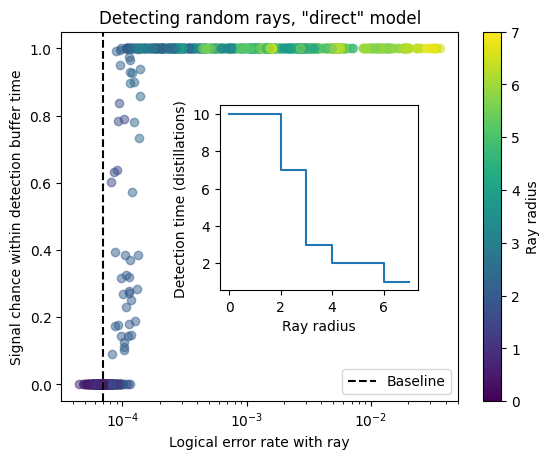

In [93]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

norm = mpl.colors.Normalize(vmin=min_radius, vmax=max_radius)
colorfunc = mpl.cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba

ax1 = plt.gca()
for i, (ler, radius) in enumerate(zip(lers_direct, radii)):
    plt.plot(ler, signal_chances_direct[i], color=colorfunc(radius), marker='o', linestyle='None', alpha=0.5)
    # text indicating radius
    # plt.text(ler, signal_chances_direct[i], f'{radius:0.1f}', fontsize=8, color='black', alpha=0.5)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), label='Ray radius', ax=plt.gca())
plt.axvline(baseline_result.errors / baseline_result.shots, color='black', linestyle='--', label='Baseline')
plt.legend()
plt.xscale('log')
plt.title('Detecting random rays, "direct" model')
plt.ylabel('Signal chance within detection buffer time')
plt.xlabel('Logical error rate with ray')

ax2 = plt.axes([0,0,1,1])
ip = mpl_toolkits.axes_grid1.inset_locator.InsetPosition(ax1, [0.4,0.3,0.5,0.5])
ax2.set_axes_locator(ip)
radii_inset = np.arange(min_radius, max_radius+1)
ax2.step(radii_inset, [get_num_cycles(radius)/18 for radius in radii_inset], where='post')
ax2.set_xlabel('Ray radius')
ax2.set_ylabel('Detection time (distillations)')

plt.savefig('ray_detection_direct.pdf', bbox_inches='tight')

plt.show()

# TODO: inset showing radius vs num_cycles

In [8]:
min_radius = 4
max_radius = 6
num_rays = 1000

def get_num_cycles(radius):
    if radius >= 6:
        num_cycles = 10*6*3
    elif radius >= 4:
        num_cycles = 10*6*3
    elif radius >= 3:
        num_cycles = 10*6*3
    elif radius >= 2:
        num_cycles = 10*6*3
    else:
        num_cycles = 10*6*3
    return num_cycles

def get_signal_chance_and_task(i):
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
    patch.noise_params.cosmic_ray_params.model = RayModelType.SCRAMBLING
    center_qubit = np.random.randint(0, len(patch.patch.all_qubits))
    radius = np.random.uniform(min_radius, max_radius)
    patch.force_cosmic_ray(center_qubit, radius)

    sim = RayImpactSimulator(patch, min(int(radius), dx, dz))
    # sim = RayImpactSimulator(patch, 2)
    temporal_window_size = 6*3
    num_cycles = get_num_cycles(radius)
    detection_fpr = 1e-10

    ray_detector_rates = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
    ray_qubit_rates = get_qubit_rates(ray_detector_rates, syndrome_qubits)

    signal_chance = sim.calc_signal_chance(baseline_qubit_rates, ray_qubit_rates, num_cycles, temporal_window_size, detection_fpr)
    task = patch.patch.get_sinter_task(task_kwargs={'json_metadata':{'i':i,'center_qubit':center_qubit, 'radius':radius}})

    return signal_chance, task

with mp.Pool(6) as pool:
    combined_results = pool.map(get_signal_chance_and_task, range(num_rays))

signal_chances_scrambling = [result[0] for result in combined_results]
tasks_scrambling = [result[1] for result in combined_results]

In [9]:
results_scrambling = sinter.collect(tasks=tasks_scrambling, num_workers=6, decoders='pymatching', max_shots=10**6, max_errors=500)

In [12]:
lers_scrambling = [None]*num_rays
radii = [0]*num_rays
for task_result in results_scrambling:
    lers_scrambling[task_result.json_metadata['i']] = task_result.errors / task_result.shots
    radii[task_result.json_metadata['i']] = task_result.json_metadata['radius']

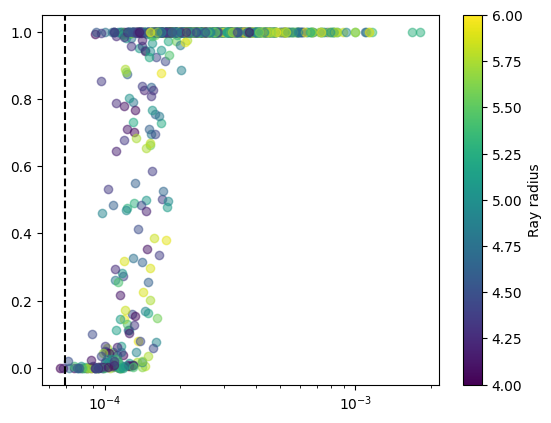

In [14]:
norm = mpl.colors.Normalize(vmin=min_radius, vmax=max_radius)
colorfunc = mpl.cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba

for i, (ler, radius) in enumerate(zip(lers_scrambling, radii)):
    plt.plot(ler, signal_chances_scrambling[i], color=colorfunc(radius), marker='o', linestyle='None', alpha=0.5)
    # text indicating radius
    # plt.text(ler, signal_chances_scrambling[i], f'{radius:0.1f}', fontsize=8, color='black', alpha=0.5)
# plt.scatter(lers_scrambling, signal_chances_scrambling, label='Scrambling')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), label='Ray radius', ax=plt.gca())
plt.axvline(baseline_result.errors / baseline_result.shots, color='black', linestyle='--', label='Baseline')
plt.xscale('log')

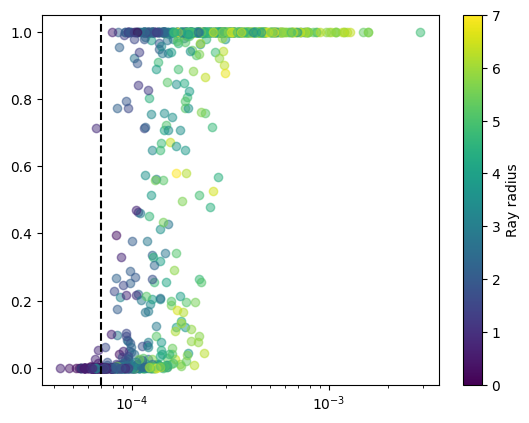

In [105]:
# window size = ray radius

for i, (ler, radius) in enumerate(zip(lers_scrambling, radii)):
    plt.plot(ler, signal_chances_scrambling[i], color=colorfunc(radius), marker='o', linestyle='None', alpha=0.5)
    # text indicating radius
    # plt.text(ler, signal_chances_scrambling[i], f'{radius:0.1f}', fontsize=8, color='black', alpha=0.5)
# plt.scatter(lers_scrambling, signal_chances_scrambling, label='Scrambling')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), label='Ray radius', ax=plt.gca())
plt.axvline(baseline_result.errors / baseline_result.shots, color='black', linestyle='--', label='Baseline')
plt.xscale('log')

Finding required detection time:

For each combination of radius and strength:
- Get detector spec for a ray in the center of patch (we care about baseline
  signal rate and signal rate in any given round of the ray)
- iteratively increase detection latency until probability of signal is greater
  than some value

For scrambling model, want to ignore cases where infidelity is too low...

Optimizing detection time for direct model: Just do a linspace of radii, and
make sure we can confidently detect each one.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats
import qc_utils.matplotlib_setup as mpl_setup
import multiprocess as mp

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
dx = 9
dz = 9
dm = 3

mpmath.mp.dps = 50

In [3]:
def get_qubit_rates(detector_fractions, syndrome_qubits):
    rates = {}
    for i, syndrome_qubit in enumerate(syndrome_qubits):
        rates[syndrome_qubit.idx] = detector_fractions[i]
    return rates

In [4]:
patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
baseline_detections = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
syndrome_qubits = patch.patch.get_syndrome_qubits()
baseline_qubit_rates = get_qubit_rates(baseline_detections, syndrome_qubits)

In [5]:
radii = np.linspace(2, 8, 40)

In [6]:
def get_detection_latency(radius):

    print(radius, end=' ')

    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
    patch.noise_params.cosmic_ray_params.model = RayModelType.DIRECT
    center_qubit = patch.patch.device[dx][dz].idx
    patch.force_cosmic_ray(center_qubit, radius)
    affected_qubits = patch.noise_model.active_cosmic_rays[0].affected_qubits

    sim = RayImpactSimulator(patch, 2, only_full_windows=True)
    # sim = RayImpactSimulator(patch, 2)
    temporal_window_size = 6*dm
    detection_fpr = 1e-10

    ray_detector_rates = np.mean(patch.patch.count_detection_events(10**6)[0], axis=0)
    ray_qubit_rates = get_qubit_rates(ray_detector_rates, syndrome_qubits)

    num_cycles = sim.find_num_cycles(baseline_qubit_rates, ray_qubit_rates, mpmath.mpf(1-1e-6), temporal_window_size, detection_fpr, affected_qubits)

    return num_cycles

In [7]:
get_detection_latency(5)

5 [[105, 106, 115, 116], [106, 107, 116, 117], [107, 108, 117, 118], [115, 116, 123, 124], [116, 117, 124, 125], [117, 118, 125, 126], [123, 124, 133, 134], [124, 125, 134, 135], [125, 126, 135, 136]] [40, 21, 22, 23, 105, 106, 107, 108, 29, 30, 31, 32, 33, 115, 116, 117, 118, 38, 39, 41, 42, 123, 124, 125, 126, 47, 48, 49, 50, 51, 133, 134, 135, 136, 57, 58, 59]


26

In [8]:
with mp.Pool(6) as pool:
    cycle_counts = pool.map(get_detection_latency, radii)

cycle_counts = np.array(cycle_counts)

2.30769230769230752.61538461538461542.02.92307692307692343.2307692307692313.5384615384615383      

[[116, 117, 124, 125]] [40, 31, 116, 117, 39, 41, 124, 125, 49]
[[116, 117, 124, 125]] [40, 116, 117, 124, 125]2.4615384615384617
 2.1538461538461537 [[116, 117, 124, 125]] [[106, 107, 116, 117], [115, 116, 123, 124], [116, 117, 124, 125], [117, 118, 125, 126], [124, 125, 134, 135]][[116, 117, 124, 125]][[106, 107, 116, 117], [115, 116, 123, 124], [116, 117, 124, 125], [117, 118, 125, 126], [124, 125, 134, 135]][40, 31, 116, 117, 39, 41, 124, 125, 49]   
[40, 30, 31, 32, 116, 117, 39, 41, 124, 125, 48, 49, 50][40, 106, 107, 30, 31, 32, 115, 116, 117, 118, 39, 41, 123, 124, 125, 126, 48, 49, 50, 134, 135][40, 106, 107, 30, 31, 32, 115, 116, 117, 118, 39, 41, 123, 124, 125, 126, 48, 49, 50, 134, 135]


2.7692307692307693.076923076923077  3.6923076923076925 3.3846153846153846 [[116, 117, 124, 125]] [40, 31, 116, 117, 39, 41, 124, 125, 49]
3.8461538461538463 [[116, 117, 124, 125]] [40, 31, 116, 117, 39, 41, 124, 125, 49]
4.153846153846154 [[116, 117, 124, 125]] [40, 31, 116, 117, 39, 41, 1

Text(0.5, 1.0, 'Number of cycles to detect ray in every affected window')

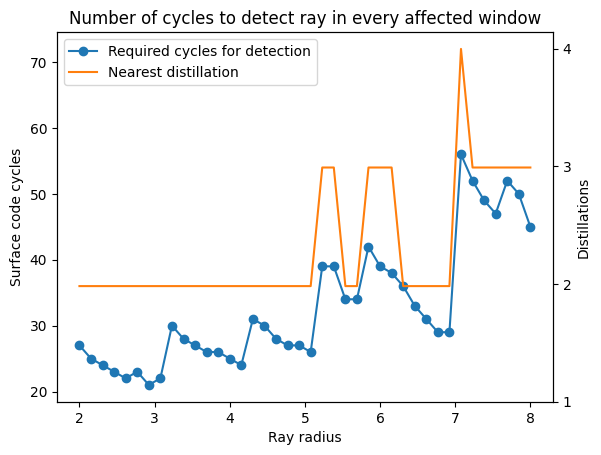

In [22]:
plt.plot(radii, cycle_counts, 'o-', label='Required cycles for detection')
plt.plot(radii, np.ceil(cycle_counts / 6 / dm) * 6*dm, label='Nearest distillation')

plt.legend()
plt.xlabel('Ray radius')

ax = plt.gca()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim()[0]/6/dm, ax.get_ylim()[1]/6/dm)

ax.set_ylabel('Surface code cycles')
ax1.set_ylabel('Distillations')
ax1.set_yticks(range(int(ax1.get_ylim()[0]), int(ax1.get_ylim()[1])+1))

plt.title('Number of cycles to detect ray in every affected window')

In [10]:
radii

array([2.        , 2.15384615, 2.30769231, 2.46153846, 2.61538462,
       2.76923077, 2.92307692, 3.07692308, 3.23076923, 3.38461538,
       3.53846154, 3.69230769, 3.84615385, 4.        , 4.15384615,
       4.30769231, 4.46153846, 4.61538462, 4.76923077, 4.92307692,
       5.07692308, 5.23076923, 5.38461538, 5.53846154, 5.69230769,
       5.84615385, 6.        , 6.15384615, 6.30769231, 6.46153846,
       6.61538462, 6.76923077, 6.92307692, 7.07692308, 7.23076923,
       7.38461538, 7.53846154, 7.69230769, 7.84615385, 8.        ])

In [11]:
get_detection_latency(6.3)

6.3 [[97, 98, 105, 106], [98, 99, 106, 107], [99, 100, 107, 108], [104, 105, 114, 115], [105, 106, 115, 116], [106, 107, 116, 117], [107, 108, 117, 118], [108, 109, 118, 119], [114, 115, 122, 123], [115, 116, 123, 124], [116, 117, 124, 125], [117, 118, 125, 126], [118, 119, 126, 127], [122, 123, 132, 133], [123, 124, 133, 134], [124, 125, 134, 135], [125, 126, 135, 136], [126, 127, 136, 137], [133, 134, 141, 142], [134, 135, 142, 143], [135, 136, 143, 144]] [40, 13, 97, 98, 99, 100, 20, 21, 22, 23, 24, 104, 105, 106, 107, 108, 109, 29, 30, 31, 32, 33, 114, 115, 116, 117, 118, 119, 37, 38, 39, 41, 42, 43, 122, 123, 124, 125, 126, 127, 47, 48, 49, 50, 51, 132, 133, 134, 135, 136, 137, 56, 57, 58, 59, 60, 141, 142, 143, 144, 67]


34

In [12]:
get_detection_latency(6.5)

6.5 [[88, 89, 98, 99], [97, 98, 105, 106], [98, 99, 106, 107], [99, 100, 107, 108], [104, 105, 114, 115], [105, 106, 115, 116], [106, 107, 116, 117], [107, 108, 117, 118], [108, 109, 118, 119], [113, 114, 121, 122], [114, 115, 122, 123], [115, 116, 123, 124], [116, 117, 124, 125], [117, 118, 125, 126], [118, 119, 126, 127], [119, 120, 127, 128], [122, 123, 132, 133], [123, 124, 133, 134], [124, 125, 134, 135], [125, 126, 135, 136], [126, 127, 136, 137], [133, 134, 141, 142], [134, 135, 142, 143], [135, 136, 143, 144], [142, 143, 152, 153]] [40, 12, 13, 14, 97, 98, 99, 100, 20, 21, 22, 23, 24, 104, 105, 106, 107, 108, 109, 28, 29, 30, 31, 32, 33, 34, 114, 115, 116, 117, 118, 119, 37, 38, 39, 41, 42, 43, 122, 123, 124, 125, 126, 127, 46, 47, 48, 49, 50, 51, 52, 132, 133, 134, 135, 136, 137, 56, 57, 58, 59, 60, 141, 142, 143, 144, 66, 67, 68]


83

TODO: want EVERY window in which all qubits had ray hits to have at least 1-1e-6 chance of signalling...